In [1]:
import numpy as np
import scipy.stats
import pandas
import matplotlib.pyplot as plt
import matplotlib.patches
from aisynphys.database import default_db as db
from aisynphys.stochastic_release_model import StochasticModelRunner, list_cached_results
from aisynphys.ui.notebook import swarm, compose_svg_figure
from aisynphys.ui.progressbar import ProgressBar

A) Example distributions of PSP amplitudes

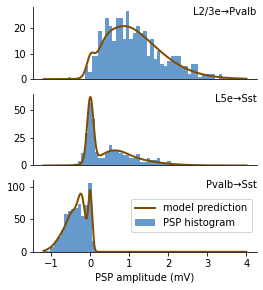

In [2]:
example_synapses = [
    (('1535402792.695', '8', '7'), 'L2/3e→Pvalb'),
    (('1535150219.310', '5', '3'), 'L5e→Sst'),
    (('1507066013.465', '5', '7'), 'Pvalb→Sst'),
]

cache_path = "/allen/programs/celltypes/workgroups/synphys/stochastic_model_results/cache/stochastic_model_results"

fig_a, ax = plt.subplots(len(example_synapses), figsize=(4, 1.5*len(example_synapses)), sharex=True)

bins = np.linspace(-1.2e-3, 4e-3, 60)
model_x = np.linspace(-1.2e-3, 4e-3, 400)
model_dx = model_x[1] - model_x[0]
bin_dx = bins[1] - bins[0]

for i, (syn_id, syn_desc) in enumerate(example_synapses):
    # load cached model results
    mr = StochasticModelRunner(db, *syn_id, cache_path=cache_path)

    # draw PSP amplitude histogram
    spike_times, amps, bg_amps, meta = mr.synapse_events
    ax[i].hist(amps*1000, bins=bins*1000, color=(.4, .6, .8), label="PSP histogram")
    
    # draw average model distribution
    br = mr.best_result()
    hist_integral = np.histogram(amps, bins=bins)[0].sum() * bin_dx
    model_dist = br.avg_model_amp_distribution(model_x) * hist_integral
    ax[i].plot(model_x*1000, model_dist, color=(.5, 0.3, 0), linewidth=2, label="model prediction")
    
    # fix up plot
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    if i < len(example_synapses) - 1:
        ax[i].get_xaxis().set_visible(False)
        
    # add text
    ax[i].text(
        1.0, 1.0, syn_desc,
        ha='right', va='top',
        transform=ax[i].transAxes
    )
    
ax[-1].set_xlabel('PSP amplitude (mV)')
ax[-1].legend(loc="center right")

B) Evolution of PSP amplitude distribution during a spike train

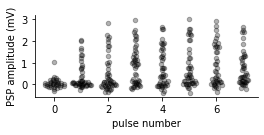

In [3]:
# E→Sst synapses
#example_synapse = ('1535150219.310', '5', '3')  # binomial-looking distributions
example_synapse = ('1534372643.843', '7', '5')

# I→Vip
#example_synapse = ('1575494792.651', '2', '1')
#example_synapse = ('1540841956.991', '3', '6')  # facilitating

mr = StochasticModelRunner(db, *example_synapse, cache_path=cache_path)
br = mr.best_result()

fig_b, ax = plt.subplots(1, figsize=(4, 1.5))
amps = []
for i in range(8):
    pulse = i + 1
    event_mask = (br.event_meta['pulse_number'] == pulse) #& (br.event_meta['induction_frequency'] == 50)
    event_inds = br.event_meta[event_mask].index
    amps.append(br.result['amplitude'][event_inds])
    
x = swarm(amps)
ax.scatter(np.concatenate(x), np.concatenate(amps)*1000, color=(0, 0, 0, 0.3), s=20)
ax.set_xlabel('pulse number')
ax.set_ylabel('PSP amplitude (mV)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


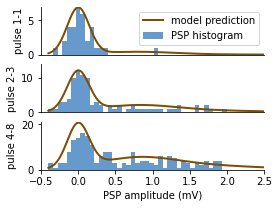

In [4]:
pulses = [(1, 1), (2, 3), (4, 8)]
bins = np.linspace(-.4e-3, 2e-3, 40)
model_x = np.linspace(-.4e-3, 3e-3, 300)

fig_c, ax = plt.subplots(len(pulses), figsize=(4, 1 * len(pulses)), sharex=True)

for i,pulse in enumerate(pulses):
    event_mask = (br.event_meta['pulse_number'] >= pulse[0]) & (br.event_meta['pulse_number'] <= pulse[1])
    event_inds = br.event_meta[event_mask].index
    amps = br.result['amplitude'][event_inds]
    amp_hist = np.histogram(amps, bins=bins)[0]
    
    ax[i].hist(amps*1000, bins=bins*1000, color=(.4, .6, .8), label='PSP histogram')
    
    hist_integral = amp_hist.sum() * bin_dx
    model_dist = br.avg_model_amp_distribution(model_x, index=event_inds) * hist_integral
    ax[i].plot(model_x*1000, model_dist, color=(.5, 0.3, 0), linewidth=2, label='model prediction')
        
    ax[i].set_ylim(0, 7*(i+1))
    
    # fix up plot
    ax[i].set_ylabel('pulse %d-%d' % (pulse))
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    if i < len(pulses) - 1:
        ax[i].get_xaxis().set_visible(False)

ax[0].set_xlim(-0.5, 2.5)
ax[-1].set_xlabel('PSP amplitude (mV)')
ax[0].legend()

C,D) Heatmap of model likelihood for two synapses over a slice of parameter space

<Pair 1530559621.966 7 6> pre: in pvalb  post: in pvalb
<Pair 1535150219.310 5 3> pre: ex unknown  post: in sst


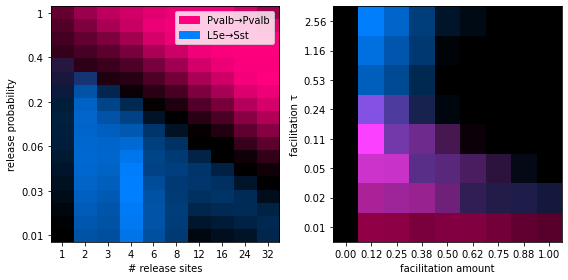

In [5]:
example_synapses = [
#    (StochasticModelRunner(db, '1535402792.695', '8', '7'), (1, 0, .5), 'ex→pv'),
    (StochasticModelRunner(db, '1530559621.966', '7', '6', cache_path=cache_path), (1, 0, .5), 'Pvalb→Pvalb'),    
    (StochasticModelRunner(db, '1535150219.310', '5', '3', cache_path=cache_path), (0, .5, 1), 'L5e→Sst'),
]

show_params = [
    ('n_release_sites', 'base_release_probability'),
#     ('desensitization_amount', 'facilitation_amount'),
#    ('vesicle_recovery_tau', 'desensitization_amount'),
    ('facilitation_amount', 'facilitation_tau'),
]

# grab any model runner so we can ask about the shap[e of the parameter space
any_mr = example_synapses[0][0]
param_order = any_mr.param_space.param_order
all_params = any_mr.param_space.axes()

# simplify ticks for release probability axis
pr_vals = all_params['base_release_probability']['values']
n_pr_ticks = 6
pr_tick_pos = np.linspace(0, len(pr_vals)-1, n_pr_ticks)
step = (pr_vals[-1] / pr_vals[0]) ** (1/(n_pr_ticks - 1))
pr_tick_vals = pr_vals[0] * step ** np.arange(n_pr_ticks)

param_formats = {
    'n_release_sites': ('{:d}', '# release sites', None),
    'base_release_probability': ('{:.1g}', "release probability", (pr_tick_pos, pr_tick_vals)),
    'depression_amount': ('{:.2f}', "depression amount", None),
    'facilitation_amount': ('{:.2f}', "facilitation amount", None),
    'facilitation_tau': ('{:.2f}', "facilitation τ", None),
}

# print some information about the selected synapses
for mr, color, label in example_synapses:
    pair = mr.get_pair()
    pre = pair.pre_cell
    post = pair.post_cell
    print(f"{pair} pre: {pre.cell_class} {pre.cre_type}  post: {post.cell_class} {post.cre_type}")

fig_d, ax = plt.subplots(1, len(show_params), figsize=(4 * len(show_params), 4))
fig_d.subplots_adjust(wspace=0.2)

for i, (x_param, y_param) in enumerate(show_params):\
    # initialize image to have correct shape
    axes = [param_order.index(x_param), param_order.index(y_param)]
    param_space_shape = any_mr.param_space.result.shape
    img_shape = (param_space_shape[axes[1]], param_space_shape[axes[0]])
    img = np.zeros(img_shape + (3,))
    
    for model_runner, color, label in example_synapses:
        result = model_runner.param_space.result['likelihood']
        
        # transpose result so visualized axes are first (y, x, ...)
        tr_axes = list(range(result.ndim))
        for j in axes:
            tr_axes.remove(j)
            tr_axes.insert(0, j)
        result = result.transpose(tr_axes)
        
        # take max over all axes except those selected for visualization
        while result.ndim > 2:
            result = result.max(axis=2)
            
        # rescale result to show more contrast in high-likelihood regions
        mn, mx = np.median(result), result.max()
        result = np.clip((result - mn) / (mx - mn), 0, 1) 

        # add result color to image
        color = np.array([[color]])        
        img += result[..., None] * color
            
    # show image
    ax[i].imshow(img / img.max(), aspect='auto')
    
    # set x label and ticks
    for xy, param in [('x', x_param), ('y', y_param)]:
        tick_format, label, ticks = param_formats[param]
        if ticks is None:
            tick_vals = all_params[param]['values']
            tick_pos = range(len(tick_vals))
        else:
            tick_pos, tick_vals = ticks
        tick_labels = [tick_format.format(x) for x in tick_vals]
        getattr(ax[i], f'set_{xy}label')(label)
        getattr(ax[i], f'set_{xy}ticks')(tick_pos)
        getattr(ax[i], f'set_{xy}ticklabels')(tick_labels)
    
    ax[i].invert_yaxis()
    
# add legend
patches = [matplotlib.patches.Patch(color=color, label=label) for mr, color, label in example_synapses]
ax[0].legend(handles=patches)
fig_d.tight_layout()

In [6]:
np.product(model_runner.param_space.result.shape)


6220800

In [7]:
model_runner.param_space.result.ndim

7

E) Model preference for release-dependent vs release-independent depression

In [8]:
q = db.pair_query(
    synapse=True,
    project_name=['mouse V1 coarse matrix', 'mouse V1 pre-production', 'human coarse matrix']
)
q = (q     
     .join(db.SynapseModel)
     .add_entity(db.SynapseModel)
     .add_entity(db.Dynamics)
     .add_entity(db.Synapse)
     .filter(db.SynapseModel.n_source_events >= 100)
)

syn = q.dataframe()

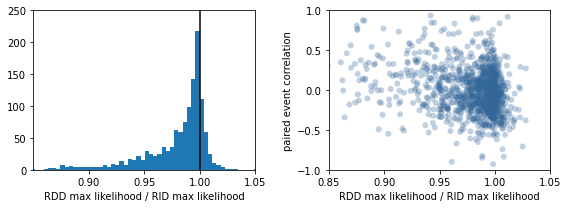

In [9]:
fig_e, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].hist(syn['ml_release_dependence_ratio'], bins=100)
ax[0].set(xlim=(0.85, 1.05), ylim=[0, 250], xlabel='RDD max likelihood / RID max likelihood')
ax[0].axvline(1, color=(0, 0, 0))
ax[0].set_xticks([0.9, 0.95, 1.0, 1.05])
ax[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax[1].scatter(
    syn['ml_release_dependence_ratio'],
    syn['paired_event_correlation_4_8_r'], 
    color=(0.2, 0.4, 0.6, 0.3), 
    edgecolors='none',
)
ax[1].set(xlim=[0.85, 1.05], ylim=[-1, 1], xlabel='RDD max likelihood / RID max likelihood', ylabel='paired event correlation')

fig_e.tight_layout()

Combine all subfigures into one using svgutils

In [10]:
label_opts = {'size': '16pt', 'font': 'arial', 'weight': 'bold'}

figure_spec = [
    {'figure': fig_a, 'pos': (0, 20), 'label': 'A', 'label_opts': label_opts},
    {'figure': fig_b, 'pos': (270, 5), 'label': 'B', 'label_opts': label_opts},
    {'figure': fig_c, 'pos': (270, 130), 'label': 'C', 'label_opts': label_opts},
    {'figure': fig_d, 'pos': (0, 350), 'label': 'D', 'label_opts': label_opts},
    {'figure': fig_e, 'pos': (0, 630), 'label': 'E', 'label_opts': label_opts},
]

compose_svg_figure(figure_spec, size=('6in', '9in'), filename='Figure S11.svg', display=True)

Analysis of model results

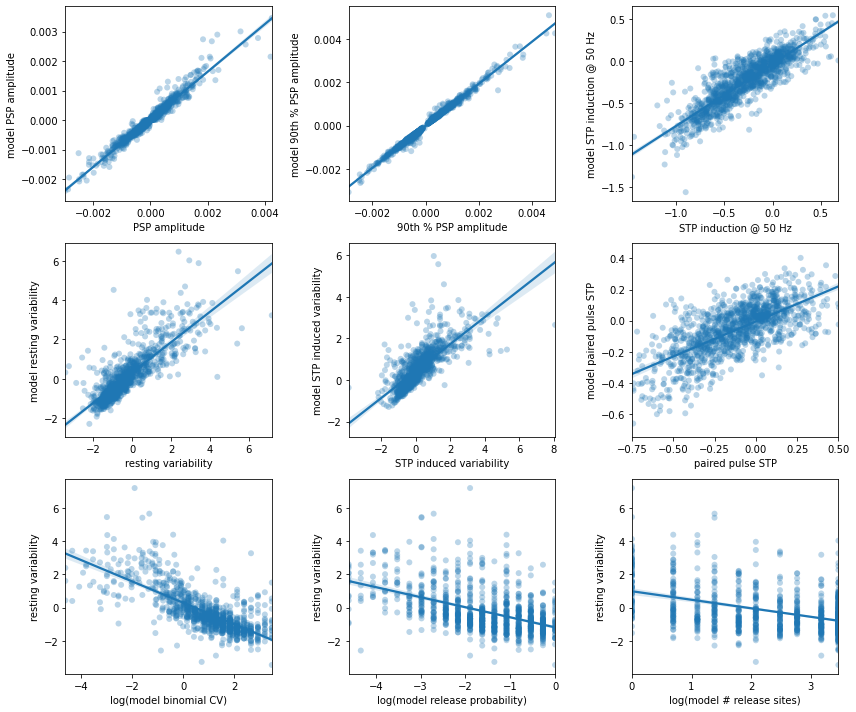

In [11]:
# does model capture amplitude correctly?
import seaborn as sns

scatter_kws = {
    'alpha':0.3,
    'edgecolors': 'none',
}

fig,ax = plt.subplots(3, 3, figsize=(12, 10))
sns.regplot(data=syn, x='psp_amplitude', y='ml_strength', ax=ax[0,0], scatter_kws=scatter_kws)
ax[0, 0].set(xlabel='PSP amplitude', ylabel='model PSP amplitude')
sns.regplot(data=syn, x='pulse_amp_90th_percentile', y='ml_pulse_amp_90th_percentile', ax=ax[0,1], scatter_kws=scatter_kws)
ax[0, 1].set(xlabel='90th % PSP amplitude', ylabel='model 90th % PSP amplitude')
sns.regplot(data=syn, x='stp_induction_50hz', y='ml_stp_induction_50hz', ax=ax[0,2], scatter_kws=scatter_kws)
ax[0, 2].set(xlabel='STP induction @ 50 Hz', ylabel='model STP induction @ 50 Hz')

sns.regplot(data=syn, x='variability_resting_state', y='ml_variability_resting_state', ax=ax[1,0], scatter_kws=scatter_kws)
ax[1, 0].set(xlabel='resting variability', ylabel='model resting variability')
sns.regplot(data=syn, x='variability_stp_induced_state_50hz', y='ml_variability_stp_induced_state_50hz', ax=ax[1,1], scatter_kws=scatter_kws)
ax[1, 1].set(xlabel='STP induced variability', ylabel='model STP induced variability')
sns.regplot(data=syn, x='stp_initial_50hz', y='ml_stp_initial_50hz', ax=ax[1,2], scatter_kws=scatter_kws)
ax[1, 2].set(xlabel='paired pulse STP', ylabel='model paired pulse STP')
ax[1, 2].set(xlim=[-0.75, 0.5], ylim=[-0.75, 0.5])

for i,(field,title) in enumerate([
    ('ml_quanta_per_spike', 'model binomial CV'), 
    ('ml_base_release_probability', 'model release probability'), 
    ('ml_n_release_sites', 'model # release sites')]):
    syn['log_'+field] = np.log(syn[field])
    sns.regplot(data=syn, x='log_'+field, y='variability_resting_state', ax=ax[2,i], scatter_kws=scatter_kws)
    ax[2,i].set(xlabel=f"log({title})", ylabel="resting variability")
fig.tight_layout()
fig.savefig('Figure S12.svg')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'release probability')

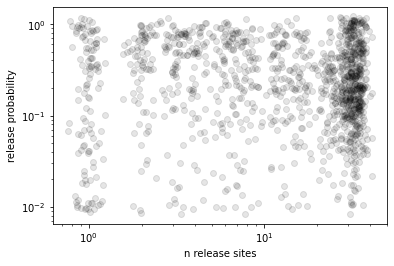

In [12]:
x = syn['ml_n_release_sites'] * np.random.normal(loc=1, scale=0.1, size=len(syn))
y = syn['ml_base_release_probability'] * np.random.normal(loc=1, scale=0.1, size=len(syn))
p = plt.scatter(x, y, c=(0, 0, 0, 0.1))
p.axes.set_xscale('log')
p.axes.set_yscale('log')
p.axes.set_xlabel('n release sites')
p.axes.set_ylabel('release probability')



E) Skewness of likelihood distribution as a measure of model fit quality

In [13]:
def model_selectivity(likelihood, alpha=0.95):
    return 1 - (likelihood > (likelihood.max() * alpha)).sum() / likelihood.size

def model_selectivity(likelihood, alpha=0.95):
    low = scipy.stats.scoreatpercentile(likelihood, (1-alpha) * 100)
    high = scipy.stats.scoreatpercentile(likelihood, alpha * 100)
    return np.log(high / low)


<ipython-input-14-c580f89fa553>:25: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax[i].set_xlim(0, results.max())


AttributeError: 'NoneType' object has no attribute 'synapse_type'

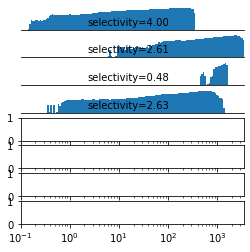

In [14]:
example_synapses = [
    ('1535402792.695', '8', '7'),
#     ('1537820585.767', '1', '2'),
#     ('1540938455.803', '6', '7'),
    ('1506536788.121', '5', '4'),
    ('1519684517.129', '1', '3'),
#     ('1535150219.310', '5', '3'),
#     ('1507066013.465', '5', '7'),
#    ('1535150219.310', '6', '8'),
    ('1551848967.996', '5', '7'),
    ('1504046236.993', '8', '2'),
    ('1500929839.690', '2', '3'),
    ('1503350239.419', '5', '4'),
    ('1556242294.782', '6', '7'),    
]

fig_e, ax = plt.subplots(len(example_synapses), 1, figsize=(4, 4), sharex=True)
bins = 10 ** np.linspace(-1, 5, 200)

for i, syn_id in enumerate(example_synapses):
    mr = StochasticModelRunner(db, *syn_id)
    results = np.ravel(mr.param_space.result['likelihood'])
    ax[i].hist(results, bins=bins)
    ax[i].set_yscale('log')
    ax[i].set_xlim(0, results.max())
    
    sel = model_selectivity(results)
    ax[i].text(0.3, 0.2, f'selectivity={sel:0.2f}', transform=ax[i].transAxes,)

    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    if i < len(example_synapses) - 1:
        ax[i].get_xaxis().set_visible(False)
    ax[i].set_xlim(0.1, 3500)
    ax[i].set_xscale('log')
        
ax[-1].set_xlabel("model likelihood")

In [ ]:
selectivity = pandas.DataFrame(columns=['syn_id', 'selectivity', 'n_events', 'amp_mean'])

cached_results = list_cached_results()

with ProgressBar('Reading model cache files..', maximum=len(cached_results)) as prg:
    for i, (syn_id, cf) in enumerate(cached_results):
        prg.update(value=i, status=f"{i+1}/{prg.maximum}  ({' '.join(syn_id)})")
        try:
            mr = StochasticModelRunner(db, *syn_id)
            n_events = np.isfinite(mr.synapse_events[1]).sum()
            sel = model_selectivity(mr.param_space.result['likelihood'])
            selectivity = selectivity.append({
                'syn_id': syn_id,
                'selectivity': sel,
                'n_events': n_events,
                'amp_mean': abs(np.nanmean(mr.synapse_events[1])),
                'hist': np.histogram(mr.synapse_events[1], bins=bins),
            }, ignore_index=True)
        except Exception as exc:
            print(syn_id, exc)
            raise
        

In [ ]:
selectivity

In [ ]:
fig, ax = plt.subplots()

ax.hist(selectivity['selectivity'], bins=30);

In [ ]:
fig, ax = plt.subplots()
ax.scatter(sel_values[:, 1], sel_values[:, 0], color=(0, 0, 0, 0.2))
#ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('selectivity')
ax.set_xlabel('# of events')

In [ ]:
mask = (sel_values[:, 0] > 4) & (sel_values[:, 1] < 20)
keys = np.array(list(selectivity.keys()))
keys[mask]